# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 1 - Parte 2

### Reglas de formato y presentation
- El trabajo debe tener una extensión máxima de 8 páginas (no se permite Apéndice). Se espera una buena redacción en la resolución del práctico.
- El informe debe ser entregado en formato PDF, con los gráficos e imágenes en este mismo archivo.
- Entregar el código con los comandos utilizados, identificando claramente a qué inciso corresponde cada comando.

### Fecha de entrega:
Miércoles 2 de octubre a las 23:59 hs.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub llamado “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 - Parte 2 deben estar dentro de esa carpeta.
- También deben enviar el link de su repositorio -para que pueda ser clonado y corregido- al siguiente email: ispiousas@udesa.edu.ar
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No envien el correo hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se corregirán sus tareas hasta no recibir el correo.
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija. 

### Parte I: Limpieza de la base

#### Ejercicio 1
La base de datos provista contiene información sobre oferentes de Airbnb en la ciudad de Nueva York. Realicen una limpieza de la base.
- Tengan en cuenta si hay valores duplicados y eliminénlos.
- Eliminen las columnas que no tienen información de interés.
- (Opcional) Luego de leer el artículo __[Missing-data imputation](https://bookdown.org/mike/data_analysis/imputation-missing-data.html##imputation-missing-data)__ (__[Missing-data imputation articulo alternativo](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)__), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
- Si hay observaciones con *outliers* o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
- Transformen las variables **‘neighbourhood_group’** y **‘room_type’** a variables numericas.
- Con la ayuda de los comandos <code>groupby</code> y <code>join</code> o <code>merge</code>, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna <code>offer group</code>

In [1]:
#IMPORTAR TODAS LAS LIBRERIAS JUNTAS 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:

# Cargar el archivo CSV
file1 = "C:/Users/Usuario/Documents/2024_UDESA/segundo semestre 2024_UDESA/ciencias de datos/TPs/ciencia-de-datos/TP2/Base_Airbnb_NY.csv"
airbnb_data = pd.read_csv(file1)

In [3]:
# Eliminar duplicados si los hay
airbnb_data_cleaned = airbnb_data.drop_duplicates()

In [4]:
# Eliminar columnas irrelevantes
columns_to_drop = ['id', 'host_id', 'last_review']
airbnb_data_cleaned = airbnb_data_cleaned.drop(columns=columns_to_drop)

In [5]:
# Imputar valores faltantes
# Imputo ambos con la mediana
median_price = airbnb_data_cleaned['price'].median()
airbnb_data_cleaned['price'] = airbnb_data_cleaned['price'].fillna(median_price)

median_review = airbnb_data_cleaned['reviews_per_month'].median()
airbnb_data_cleaned['reviews_per_month'] = airbnb_data_cleaned['reviews_per_month'].fillna(median_review)

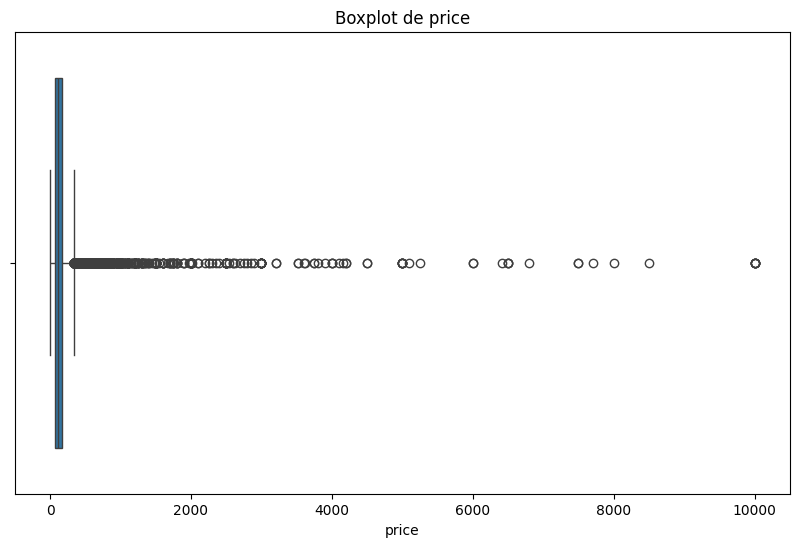

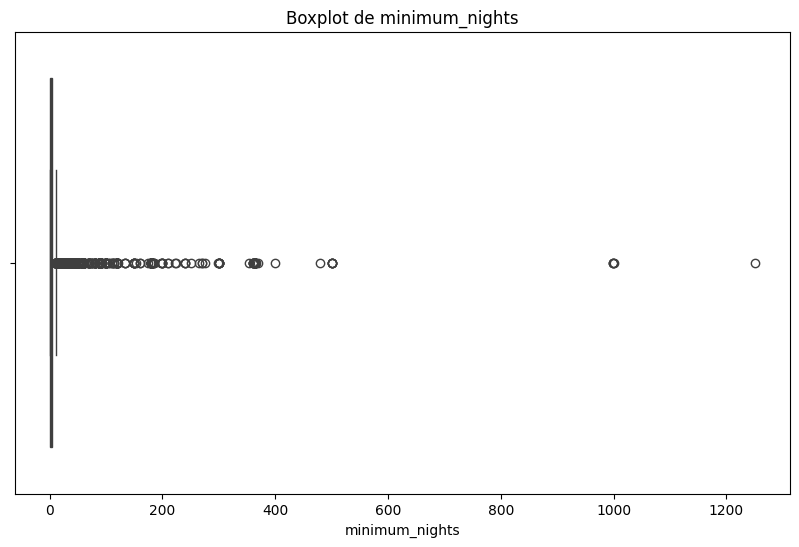

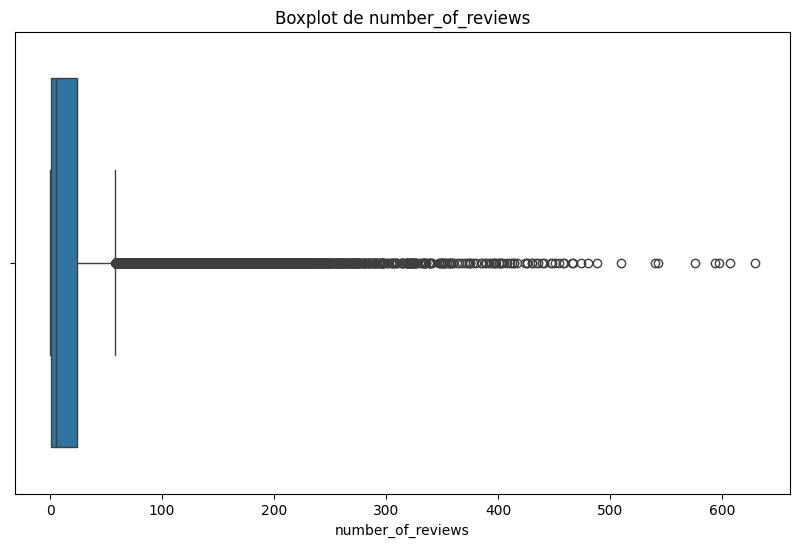

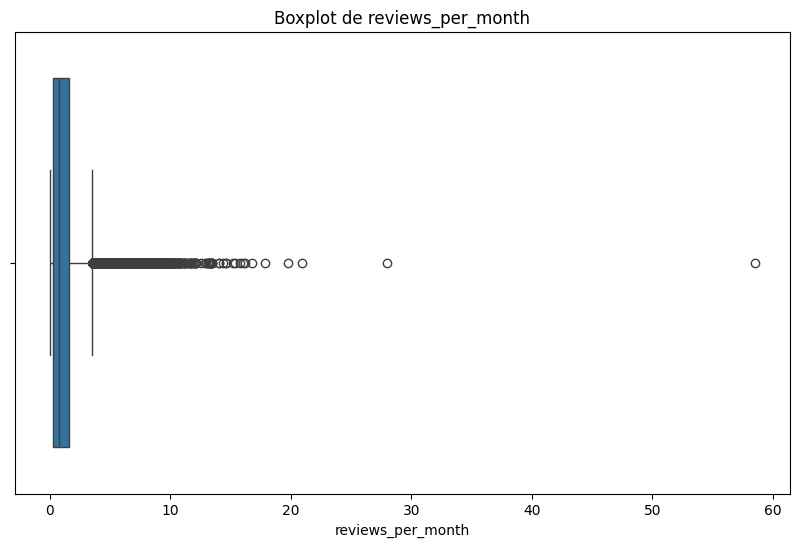

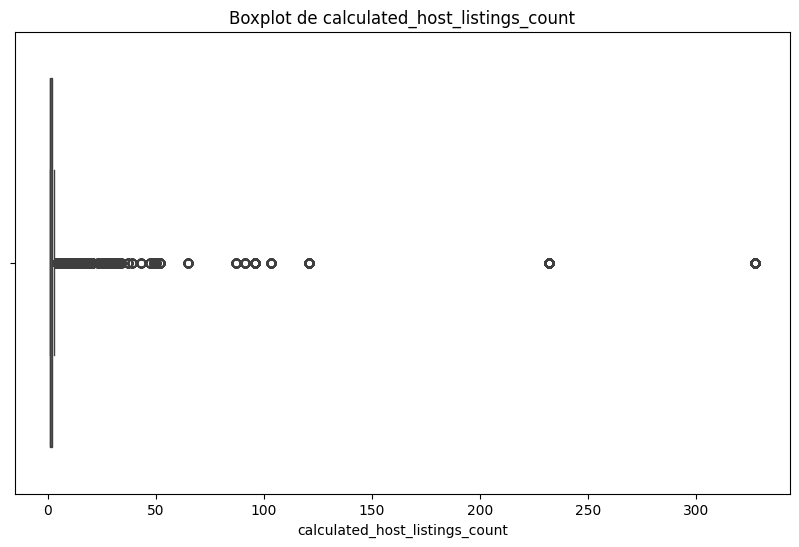

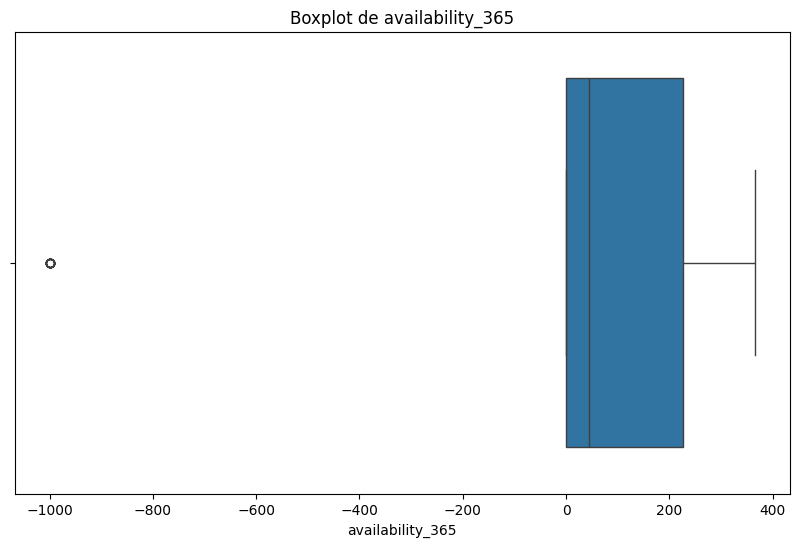

In [6]:
# Outliers 
#ANALISIS DE OUTLIERS --> PRIMERO HACEMOS BOXPLOTS PARA VER EN QUE COLUMNAS CENTRARNOS Y SI HAY QUE APLICAR LOGARITMO EN ALGUNA 


numeric_columns = ['price', 'minimum_nights', 'number_of_reviews', 
                   'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
# Visualizar outliers antes de limpiar
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=airbnb_data_cleaned[column])
    plt.title(f'Boxplot de {column}')
    plt.show()


In [7]:
# Outliers

#Observamos muchos outliers en todas las variables analizadas menos en availability_365 que tiene un numero negativo (suponemos que esta mal, porque no tiene sentido). En las demas variables vemos que hay mucha varianza por lo que para analizar los outliers les vamos a aplicar la funcion log(1+x) para disminuirla y no tener problemas con los valores 0

#sacamos negativos de  availability_365
airbnb_data_cleaned = airbnb_data_cleaned[airbnb_data_cleaned['availability_365'] >= 0]

# hacemos nuevas columnas con logaritmo  
airbnb_data_cleaned['log_price'] = np.log1p(airbnb_data_cleaned['price'])
airbnb_data_cleaned['log_minimum_nights'] = np.log1p(airbnb_data_cleaned['minimum_nights'])
airbnb_data_cleaned['log_number_of_reviews'] = np.log1p(airbnb_data_cleaned['number_of_reviews'])
airbnb_data_cleaned['log_reviews_per_month'] = np.log1p(airbnb_data_cleaned['reviews_per_month'])
airbnb_data_cleaned['log_calculated_host_listings_count'] = np.log1p(airbnb_data_cleaned['calculated_host_listings_count'])
airbnb_data_cleaned['log_availability_365'] = np.log1p(airbnb_data_cleaned['availability_365'])
#Defino las columnas donde voy a analizar outliers 

#No sacamos ouliers de minimum_nights porque tiene muchos 0. 'calculated_host_listings_count' tampoco vamos a sacar outliers, pero despues vamos a comparar modelo con y sin esta columna, esto es porque si le sacamos los outliers, todos los datos pasan a valer 1 y no podemos calcular correlacion ni nada



#analizamos columnas que pueden tener outliers   
outliers_columns = ['log_price','log_number_of_reviews', 
                   'log_reviews_per_month','log_availability_365']


# Función para calcular la Desviación Absoluta Mediana (MAD)
def mad(series):
    median_value = series.median()  # Mediana de la columna
    deviation = abs(series - median_value)  # Desviación de cada valor respecto a la mediana
    return deviation.median()  # Mediana de esas desviaciones

# Función para detectar outliers utilizando el método MAD
def detect_outliers_mad(df, column, threshold=3.0):
    # Calcular la mediana y el MAD de la columna
    median_value = df[column].median()
    mad_value = mad(df[column])  
    
    # Calcular la desviación absoluta respecto a la mediana
    deviation_from_median = abs(df[column] - median_value)
    
    # Detectar outliers usando el umbral de 3 veces el MAD
    outliers = deviation_from_median > threshold * mad_value
    return outliers

# Aplicar la función de detección de outliers para cada columna y agregar una nueva columna que marque los outliers
for column in outliers_columns:
    airbnb_data_cleaned[f'{column}_outlier'] = detect_outliers_mad(airbnb_data_cleaned, column)
#airbnb_data_cleaned.head() #48895 registros 

#Dejamos solo los registros que no tengan outliers en ninguna columna 

# Crear un DataFrame temporal SOLO con las columnas que indican outliers
outliers_flags = airbnb_data_cleaned[[f'{col}_outlier' for col in outliers_columns]]

# Filtrar las filas donde NO hay ningún outlier en las columnas (mantener solo las filas sin outliers)
airbnb_data_cleaned = airbnb_data_cleaned[~outliers_flags.any(axis=1)]
# Eliminar las columnas adicionales que marcaban los outliers
airbnb_data_cleaned = airbnb_data_cleaned.drop(columns=[f'{col}_outlier' for col in outliers_columns])

print(airbnb_data_cleaned.head())
print(airbnb_data_cleaned.shape)

                                               name  host_name  \
0                Clean & quiet apt home by the park       John   
1                             Skylit Midtown Castle   Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !  Elisabeth   
4  Entire Apt: Spacious Studio/Loft by central park      Laura   
5         Large Cozy 1 BR Apartment In Midtown East      Chris   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
4           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   
5           Manhattan   Murray Hill  40.74767  -73.97500  Entire home/apt   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0  149.0               1                  9               0.21   
1  225.0

In [8]:
# Convertir 'neighbourhood_group' y 'room_type' a variables numéricas usando factorize
airbnb_data_cleaned['neighbourhood_group_num'] = pd.factorize(airbnb_data_cleaned['neighbourhood_group'])[0]
airbnb_data_cleaned['room_type_num'] = pd.factorize(airbnb_data_cleaned['room_type'])[0]

In [9]:
# Crear la columna 'offer_group' que cuenta los oferentes por 'neighbourhood_group'
offer_group = airbnb_data_cleaned.groupby('neighbourhood_group')['neighbourhood_group'].transform('count')
airbnb_data_cleaned['offer_group'] = offer_group

In [10]:
# Verificar los primeros registros con la nueva columna y las imputaciones
airbnb_data_cleaned.head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,availability_365,log_price,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,neighbourhood_group_num,room_type_num,offer_group
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,...,365,5.010635,0.693147,2.302585,0.190620,1.945910,5.902633,0,0,18120
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,...,355,5.420535,0.693147,3.828641,0.322083,1.098612,5.874931,1,1,18928
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,...,365,5.017280,1.386294,0.000000,0.542324,0.693147,5.902633,1,0,18928
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,...,0,4.394449,2.397895,2.302585,0.095310,0.693147,0.000000,1,1,18928
5,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3,74,...,129,5.303305,1.386294,4.317488,0.463734,0.693147,4.867534,1,1,18928


### Parte II: Graficos y visualizaciones

#### Ejercicio 2
Una vez hecha la limpieza, realicen una matriz de correlación con las siguientes variables:**‘neighbourhood group’, ‘latitude’, ‘longitude’, ‘room type’,‘price’, ‘minimum nights’, ‘number of reviews’, ‘reviews per month’,‘calculated host listings count’, ‘availability 365’.** Comenten los resultados. Utilicen alguno de los comandos disponibles en este link para graficar la matriz de correlacion.

*Nota:* consideren cómo es conveniente incluir las variables que originalmente eran categóricas para poder interpretar mejor la matriz de correlación.

In [11]:
# Resolver acá
# Seleccionar las columnas de interés para la matriz de correlación
columnas1 = ['neighbourhood_group_num', 'latitude', 'longitude', 'room_type_num', 
                       'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
                       'calculated_host_listings_count', 'availability_365']

# Calcular la matriz de correlación
correlacion = airbnb_data_cleaned[columnas1].corr()

# Mostrar la matriz de correlación
print(correlacion)

                                neighbourhood_group_num  latitude  longitude  \
neighbourhood_group_num                        1.000000  0.537163   0.271384   
latitude                                       0.537163  1.000000   0.095882   
longitude                                      0.271384  0.095882   1.000000   
room_type_num                                 -0.002534  0.003657  -0.167556   
price                                         -0.000804  0.070754  -0.294973   
minimum_nights                                 0.003153  0.026726  -0.061348   
number_of_reviews                             -0.001242 -0.023595   0.038290   
reviews_per_month                              0.070341 -0.024979   0.103477   
calculated_host_listings_count                 0.049176  0.022984  -0.117667   
availability_365                               0.123959 -0.012563   0.086062   

                                room_type_num     price  minimum_nights  \
neighbourhood_group_num             -0.00253

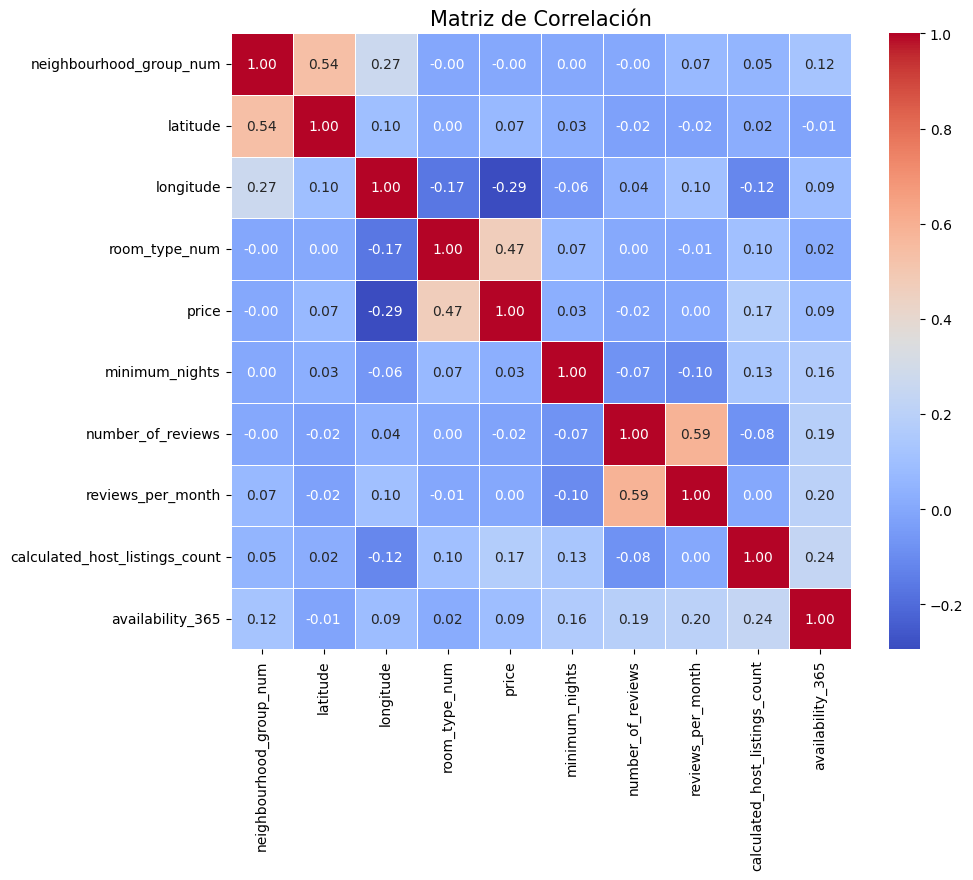

In [12]:


# Calcular la matriz de correlación
correlacion = airbnb_data_cleaned[columnas1].corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear un heatmap de la matriz de correlación
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Agregar título
plt.title('Matriz de Correlación', size=15)

# Mostrar el gráfico
plt.show()


#### Ejercicio 3
Respondan las siguientes preguntas: ¿Cuál es la proporción de oferentes por “Neighbourhood group”? ¿Y por tipo de habitación? Además, realicen gráficos para mostrar estas composiciones y comenten los resultados.

In [13]:
# Resolver acá
# Proporción de oferentes por 'Neighbourhood group'
barrio = airbnb_data_cleaned['neighbourhood_group'].value_counts(normalize=True)
barrio

neighbourhood_group
Manhattan        0.438931
Brooklyn         0.420193
Queens           0.111727
Bronx            0.021775
Staten Island    0.007374
Name: proportion, dtype: float64

In [14]:
# Proporción de oferentes por 'Room type'
cuarto = airbnb_data_cleaned['room_type'].value_counts(normalize=True)
cuarto

room_type
Entire home/apt    0.513369
Private room       0.463372
Shared room        0.023259
Name: proportion, dtype: float64

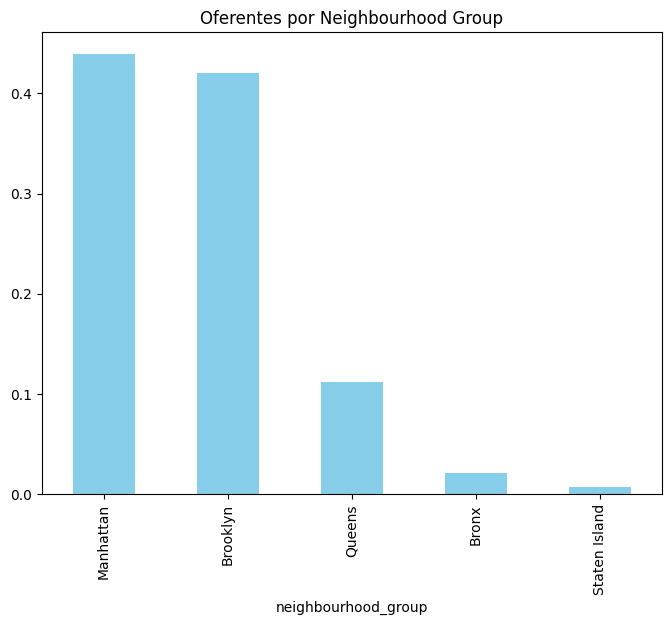

In [15]:


# Gráfico de proporción por Neighbourhood group
plt.figure(figsize=(8, 6))
barrio.plot.bar(color='skyblue')
plt.title('Oferentes por Neighbourhood Group')
plt.ylabel('')  # Borro el nombre para que no se superpongan las cosas 
plt.show()

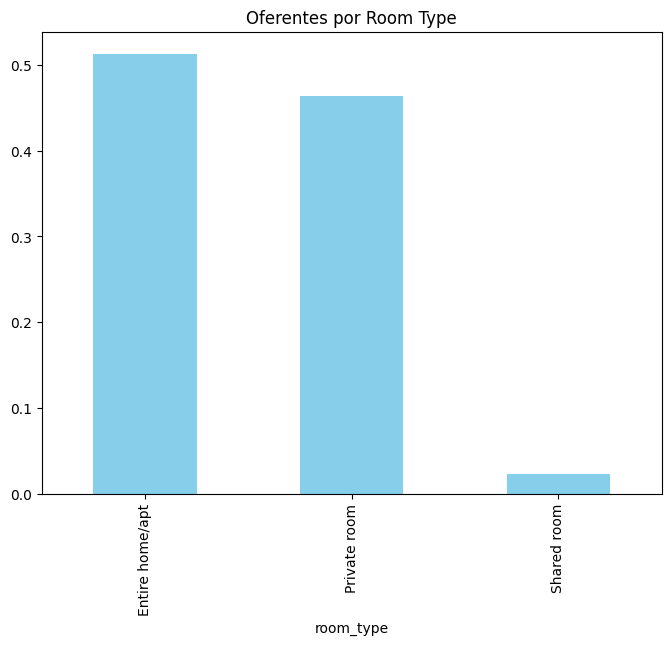

In [16]:
plt.figure(figsize=(8, 6))
cuarto.plot.bar(color='skyblue')
plt.title('Oferentes por Room Type')
plt.ylabel('')  # Borro el nombre para que no se superpongan las cosas
plt.show()

#### Ejercicio 4
Realicen un histograma de los precios de los alojamientos. Comenten el gráfico obtenido. Además, respondan las siguientes preguntas: ¿cuál es el precio mínimo, máximo y promedio? ¿Cuál es la media de precio por “Neighbourhood group” y por tipo de habitación? 

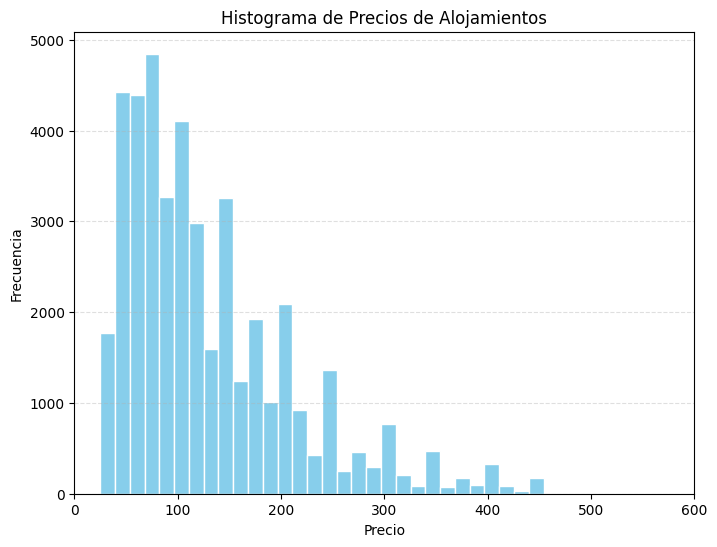

Precio mínimo: 25.0
Precio máximo: 454.0
Precio promedio: 129.90040117802565

Media de precio por 'Neighbourhood group':
neighbourhood_group
Bronx             81.448349
Brooklyn         111.568543
Manhattan        159.706202
Queens            93.599211
Staten Island     93.437107
Name: price, dtype: float64

Media de precio por tipo de habitación:
room_type
Entire home/apt    176.511157
Private room        81.492894
Shared room         65.503490
Name: price, dtype: float64


In [17]:
# Resolver acá
#Histograma
plt.figure(figsize=(8, 6))
plt.hist(airbnb_data_cleaned['price'], bins=30, color='skyblue', edgecolor='white') 
plt.title('Histograma de Precios de Alojamientos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.xlim(0, 600)  # Ajustar los límites del eje x porque sino se ve muy chiquito y no hay datos 
plt.grid(axis='y', alpha=0.4, linestyle='--') #agrego cuadricula de fondo pero medio transparente
plt.show()

# Calcular maximo, minimo y promeeio
precio_minimo = airbnb_data_cleaned['price'].min()
precio_maximo = airbnb_data_cleaned['price'].max()
precio_promedio = airbnb_data_cleaned['price'].mean()
# Media de precio por 'Neighbourhood group'
media_por_neighbourhood = airbnb_data_cleaned.groupby('neighbourhood_group')['price'].mean()
# Media de precio por tipo de habitación
media_por_tipo_habitacion = airbnb_data_cleaned.groupby('room_type')['price'].mean()

# Mostrar los resultados
print(f"Precio mínimo: {precio_minimo}")
print(f"Precio máximo: {precio_maximo}")
print(f"Precio promedio: {precio_promedio}")
print("\nMedia de precio por 'Neighbourhood group':")
print(media_por_neighbourhood)
print("\nMedia de precio por tipo de habitación:")
print(media_por_tipo_habitacion)

#### Ejercicio 5
Realicen dos scatter plots con dos variables de interés en cada uno. Comenten.

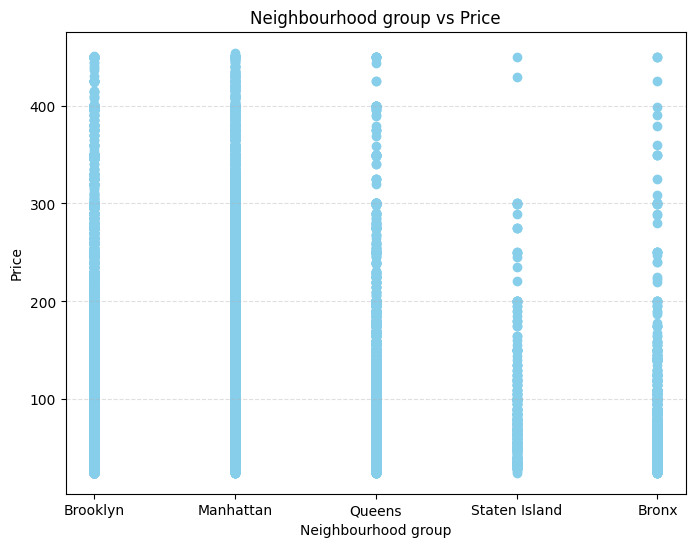

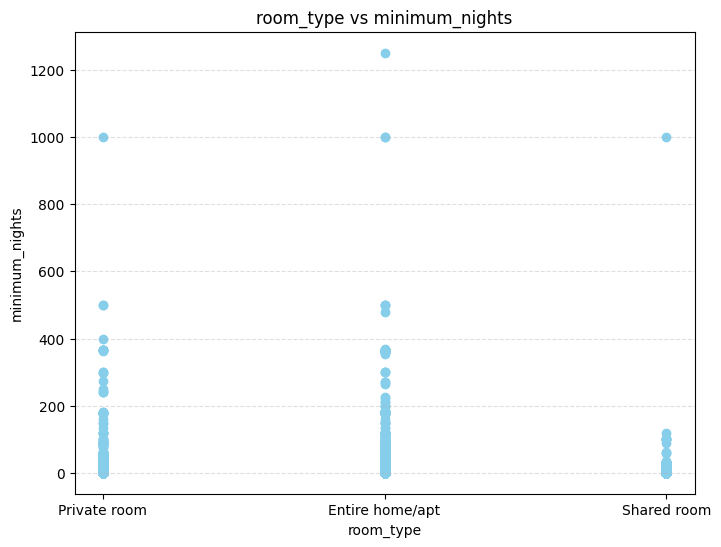

In [18]:

#Vamos a hacer un scatter plot entre las variables de neighbourhood_group con los precios, para poder ver los cambios de precios que vimos en las medias y ver como se distribuyen entre los barrios los diferentes precios
plt.figure(figsize=(8, 6))
plt.scatter(airbnb_data_cleaned['neighbourhood_group'], airbnb_data_cleaned['price'],color='skyblue')
plt.xlabel('Neighbourhood group')
plt.ylabel('Price')
plt.title('Neighbourhood group vs Price')
plt.grid(axis='y', alpha=0.4, linestyle='--') #agrego cuadricula de fondo pero medio transparente
plt.show()

#Comentario: Por un lado, vemos que Staten Island es el barrio con menos cantidad de precios altos en comparacion a los otros. Ademas, vemos que todos los barrios disponen de muchas opciones con precios bajos, teniendo una mayor varianza en la cantidad de alojamientos caros por barrio, esto es lo que ocasiona las diferencias de medias. Por ejemplo, Manhattan es el barrio mas caro en promedio, pero esto se debe a que tiene mas opciones caras que los demas, no a que no tenga muchas opciones baratas tambien.




#Vamos a hacer otro scatter plot esta vez entre el tipo de cuarto y la cantidad de noches minimas
plt.figure(figsize=(8, 6))
plt.scatter(airbnb_data_cleaned['room_type'], airbnb_data_cleaned['minimum_nights'],color='skyblue')
plt.xlabel('room_type')
plt.ylabel('minimum_nights')
plt.title('room_type vs minimum_nights')
plt.grid(axis='y', alpha=0.4, linestyle='--') #agrego cuadricula de fondo pero medio transparente
plt.show()

#Se ve que los cuartos compartidos suelen pedir menos noches minimas que los cuartos privados o las casas. Esto tiene sentido teniendo en cuenta que suelen ser alojamientos pasajeros que se utilizan durante viajes y no como vivienda fija. 

#### Ejercicio 6
Utilicen el análisis de componentes principales para graficar las variables en dos dimensiones. Comenten los resultados obtenidos (qué porcentaje de la varianza se logra explicar con dos componentes, cómo son los *loadings*, si ven algún patrón en el gráfico).

In [19]:
# Resolver acá
#NOS VAMOS A QUEDAR SOLO CON LAS VARIABLES NUMERICAS NO CATEGORICAS


var_numericas = ['log_price', 'log_minimum_nights', 'log_number_of_reviews', 'log_reviews_per_month',
                       'log_calculated_host_listings_count', 'log_availability_365']
df= airbnb_data_cleaned[var_numericas]
#veo las medias y desviaciones de todas las columnas
#print(df.mean())
#print(df.std())

#vemos que las medias no son 0 y la std no es 1 en las columnas. Tenemos que escalarlo para poder hacer componentes principales
scaler = StandardScaler(with_std=True, with_mean=True)
# Aplicamos fit_transform al DataFrame
df_transformed = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#print(df_transformed.mean()) # luego de la estandarización la media es muy cercana a cero para todas las columnas
#print(df_transformed.std()) # la desviación estandar se acerca a uno para todas las columnas

#Ahora ajustamos modelo de componentes principales 

pca = PCA(n_components=2)

modelo_pca = pca.fit_transform(df_transformed)

# Varianza explicada por los primeros dos componentes
print("Varianza explicada por los primeros 2 componentes:", pca.explained_variance_ratio_)

# Loadings vectors
loading_vectors = pca.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loading componente 1:\n", pca.components_[0])
print("Loading componente 2:\n", pca.components_[1])

Varianza explicada por los primeros 2 componentes: [0.29897618 0.2700373 ]
Loading componente 1:
 [ 0.04729573 -0.04436198  0.54696726  0.60956485  0.18204661  0.54028852]
Loading componente 2:
 [ 0.1592085   0.61415118 -0.28293466 -0.19148192  0.60746535  0.33427457]


In [20]:
#Vamos a hacer el mismo analisis pero sin la variable calculated_host_listings_count

var_numericas2 = ['log_price', 'log_minimum_nights', 'log_number_of_reviews', 'log_reviews_per_month',
                        'log_availability_365']
df2= airbnb_data_cleaned[var_numericas2]
#veo las medias y desviaciones de todas las columnas
#print(df2.mean())
#print(df2.std())

#vemos que las medias no son 0 y la std no es 1 en las columnas. Tenemos que escalarlo para poder hacer componentes principales
scaler = StandardScaler(with_std=True, with_mean=True)
# Aplicamos fit_transform al DataFrame
df_transformed2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
#print(df2_transformed.mean()) # luego de la estandarización la media es muy cercana a cero para todas las columnas
#print(df2_transformed.std()) # la desviación estandar se acerca a uno para todas las columnas



#Ahora ajustamos modelo de componentes principales 

pca2 = PCA(n_components=2)

modelo_pca2 = pca2.fit_transform(df_transformed2)

# Varianza explicada por los primeros dos componentes
print("Varianza explicada por los primeros 2 componentes:", pca2.explained_variance_ratio_)

# Loadings vectors
loading_vectors = pca2.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loading componente 1:\n", pca2.components_[0])
print("Loading componente 2:\n", pca2.components_[1])

#MEJORA MUCHO LA VARIANZA EXPLICADA

Varianza explicada por los primeros 2 componentes: [0.35638758 0.24314864]
Loading componente 1:
 [ 0.01691625 -0.16975931  0.59605681  0.63634148  0.45900046]
Loading componente 2:
 [ 0.38052664  0.74360007 -0.13666863 -0.06497104  0.52854409]


In [21]:
#Vamos a hacer el mismo analisis pero sin las transformaciones logaritmicas --> no varian mucho los valores. Log es un poquito mejor, asi que nos quedamos con ese.

var_numericas3 = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                        'availability_365']
df3= airbnb_data_cleaned[var_numericas3]
#veo las medias y desviaciones de todas las columnas
#print(df.mean())
#print(df.std())

#vemos que las medias no son 0 y la std no es 1 en las columnas. Tenemos que escalarlo para poder hacer componentes principales
scaler = StandardScaler(with_std=True, with_mean=True)
# Aplicamos fit_transform al DataFrame
df_transformed3= pd.DataFrame(scaler.fit_transform(df3), columns=df3.columns)
#print(df_transformed3.mean()) # luego de la estandarización la media es muy cercana a cero para todas las columnas
#print(df_transformed3.std()) # la desviación estandar se acerca a uno para todas las columnas



#Ahora ajustamos modelo de componentes principales 

pca3 = PCA(n_components=2)

modelo_pca3 = pca3.fit_transform(df_transformed3)

# Varianza explicada por los primeros dos componentes
print("Varianza explicada por los primeros 2 componentes:", pca3.explained_variance_ratio_)

# Loadings vectors
loading_vectors = pca3.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loading componente 1:\n", pca3.components_[0])
print("Loading componente 2:\n", pca3.components_[1])

Varianza explicada por los primeros 2 componentes: [0.34043952 0.23566716]
Loading componente 1:
 [ 0.02237499 -0.07986243  0.65595861  0.66256196  0.35192513]
Loading componente 2:
 [ 0.41064705  0.69100488 -0.1183764  -0.11676175  0.57116983]


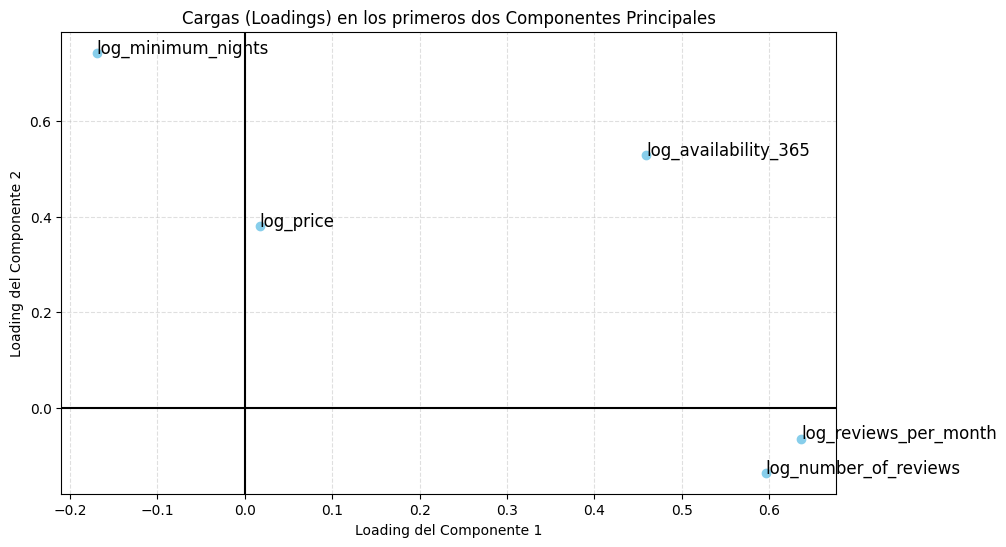

In [22]:
#Graficamos los Loading en los diferentes componentes para ver que tanto explica cada componente de esa variable a simple vista
loadings_comp1 = pca2.components_[0]  # Cargas del primer componente
loadings_comp2 = pca2.components_[1]  # Cargas del segundo componente

# Crear el gráfico de las cargas de los primeros dos componentes
plt.figure(figsize=(10, 6))
plt.scatter(loadings_comp1, loadings_comp2, color='skyblue')

etiquetas= ['Price', 'Minimum nights', 'Number of reviews', 'Reviews per month',
                        'Availability 365']
# Añadir etiquetas para cada variable en el gráfico
i=0
for  var in var_numericas2:
    plt.text(loadings_comp1[i], loadings_comp2[i], var, fontsize=12)
    i+=1
# Etiquetas de los ejes
plt.xlabel('Loading del Componente 1')
plt.ylabel('Loading del Componente 2')
plt.title('Cargas (Loadings) en los primeros dos Componentes Principales')
plt.grid(axis='y', alpha=0.4, linestyle='--')
plt.grid(axis='x', alpha=0.4, linestyle='--')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

### Parte III: Predicción

El objetivo de esta parte del trabajo es intentar predecir los precios de los alojamientos.

#### Ejercicio 7
Eliminen de la base todas las variables relacionadas al precio

In [23]:
# Resolver acá - NO SE HACE


#### Ejercicio 8
Partan la base en una base de prueba (test) y una de entrenamiento (train) utilizando el comando <code>train_test_split</code>. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (*random state instance*) debe ser 201. Establezca a price como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables ser´an las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [24]:
# Resolver acá
from sklearn.model_selection import train_test_split

# Separo la variable dependiente 'price' de las variables independientes
    # saco las variables con strings en la matriz de variables independientes 
var_indeps_df = airbnb_data_cleaned.drop(columns=['name','host_name','neighbourhood_group','neighbourhood', 'room_type','price','price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_num', 'room_type_num', 'offer_group'])    # Matriz de variables independientes 
y = airbnb_data_cleaned['log_price']    # Vector de variable dependiente


# Agrego la columna de unos a la matriz de variables independientes
var_indeps = np.hstack([np.ones((var_indeps_df.shape[0], 1)), var_indeps_df])  # np.ones añade una columna de unos al inicio de la matriz

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(var_indeps, y, test_size=0.3, random_state=201)

#### Ejercicio 9
Implementen una regresión lineal y comenten los resultados obtenidos.


Intercepto: 3.161915174132446e-13
['latitude', 'longitude', 'log_price', 'log_minimum_nights', 'log_number_of_reviews', 'log_reviews_per_month', 'log_calculated_host_listings_count', 'log_availability_365']
Parametro  latitude : 0.0
Parametro  longitude : -7.827072323607354e-15
Parametro  log_price : 7.560014391135216e-16
Parametro  log_minimum_nights : 1.0000000000000004
Parametro  log_number_of_reviews : 1.5232014402589022e-16
Parametro  log_reviews_per_month : 2.325449703959136e-16
Parametro  log_calculated_host_listings_count : -3.4484372533232054e-16
Parametro  log_availability_365 : -2.0944239287075273e-17
R^2: 1.0
MSE: 3.1361352639239674e-27


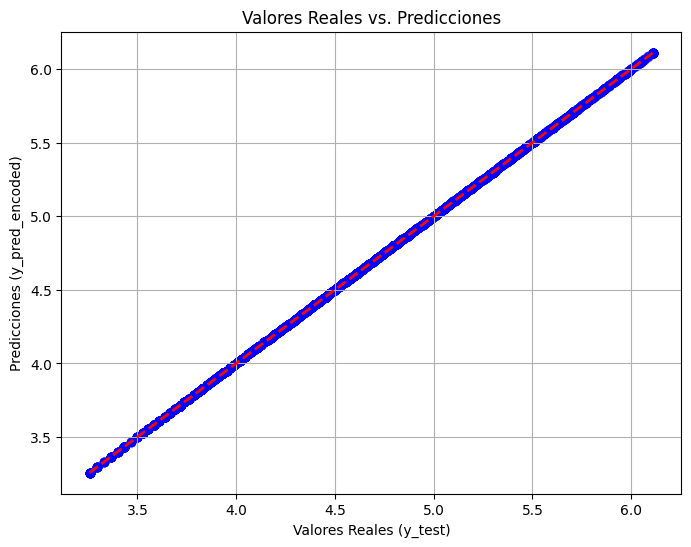

In [25]:
# Resolver acá

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_encoded, y_train)

intercepto_model = model.intercept_
print('\nIntercepto:', intercepto_model)

variables_X= list(var_indeps_df.columns)
print(variables_X)
pendiente_model = model.coef_
for  i in range (len(variables_X)):
    print('Parametro ',variables_X[i] ,":", pendiente_model[i])

# Hacer predicciones con el conjunto de prueba
y_pred_encoded = model.predict(X_test_encoded)

# Calcular métricas de rendimiento
r2_encoded = r2_score(y_test, y_pred_encoded)
mse_encoded = mean_squared_error(y_test, y_pred_encoded)

# Mostrar los resultados
print(f"R^2: {r2_encoded}")
print(f"MSE: {mse_encoded}")

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_encoded, color='blue', alpha=0.5)

# Agregar la línea de regresión perfecta (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)

# Etiquetas
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred_encoded)')
plt.grid(True)
plt.show()


Intercepto: -8.810729923425242e-13
['latitude', 'longitude', 'calculated_host_listings_count', 'log_price', 'log_minimum_nights', 'log_number_of_reviews', 'log_reviews_per_month', 'log_calculated_host_listings_count', 'log_availability_365']
Parametro  latitude : 0.0
Parametro  longitude : 1.441902153231922e-14
Parametro  calculated_host_listings_count : -3.229095854571769e-15
Parametro  log_price : 1.1874425821936892e-16
Parametro  log_minimum_nights : 0.9999999999999996
Parametro  log_number_of_reviews : -3.189087339701305e-16
Parametro  log_reviews_per_month : 1.1606192876172778e-16
Parametro  log_calculated_host_listings_count : -8.850868203951907e-17
Parametro  log_availability_365 : -6.906041708318153e-18
R^2: 1.0
MSE: 3.171185030179115e-27


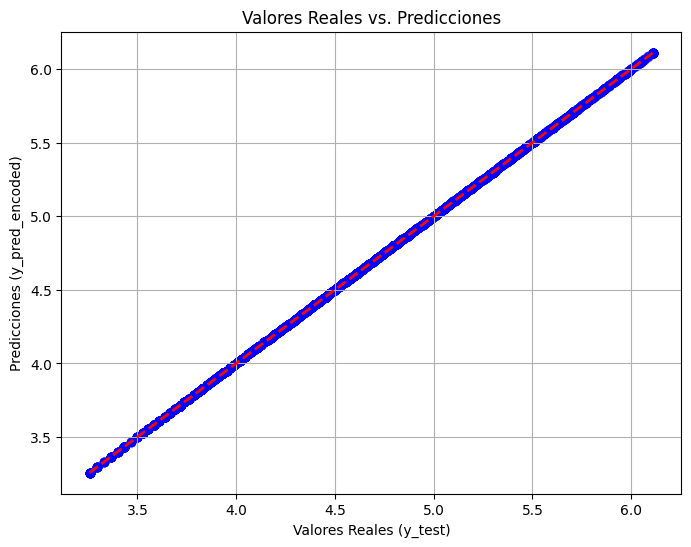

In [26]:
# agregamos calculated_host_listings_count
from sklearn.model_selection import train_test_split

# Separo la variable dependiente 'price' de las variables independientes
    # saco las variables con strings en la matriz de variables independientes 
var_indeps_df = airbnb_data_cleaned.drop(columns=['name','host_name','neighbourhood_group','neighbourhood', 'room_type','price','price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'availability_365',
       'neighbourhood_group_num', 'room_type_num', 'offer_group',])    # Matriz de variables independientes 
y = airbnb_data_cleaned['log_price']    # Vector de variable dependiente


# Agrego la columna de unos a la matriz de variables independientes
var_indeps = np.hstack([np.ones((var_indeps_df.shape[0], 1)), var_indeps_df])  # np.ones añade una columna de unos al inicio de la matriz

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(var_indeps, y, test_size=0.3, random_state=201)


# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_encoded = model.predict(X_test_encoded)

intercepto_model = model.intercept_
print('\nIntercepto:', intercepto_model)


variables_X= list(var_indeps_df.columns)
print(variables_X)
pendiente_model = model.coef_
for  i in range (len(variables_X)):
    print('Parametro ',variables_X[i] ,":", pendiente_model[i])

# Calcular métricas de rendimiento
r2_encoded = r2_score(y_test, y_pred_encoded)
mse_encoded = mean_squared_error(y_test, y_pred_encoded)

# Mostrar los resultados
print(f"R^2: {r2_encoded}")
print(f"MSE: {mse_encoded}")

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_encoded, color='blue', alpha=0.5)

# Agregar la línea de regresión perfecta (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)

# Etiquetas
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred_encoded)')
plt.grid(True)
plt.show()